# Outlier Detection and Normlizing the DEM and CAPITAL

*Date: July 18th, 2025*

*Description: This code is written to read DEM and CAPITAL tiff files and return back the normalized and cleaned version of these two. For CAPITAL, every scene with averages of zero is omitted, and for DEM every scene with averages less than zero is omitted.*

## PRELIMINARY

In [1]:
# Cleaning CAPITAL_1996
folders = {
    'dem': '/Users/sayedmorteza/Library/CloudStorage/Box-Box/Hetwet_Data/DEM',
    'cap': '/Users/sayedmorteza/Library/CloudStorage/Box-Box/Hetwet_Data/CAPITAL_1996'
}
output_dir_cap = '/Users/sayedmorteza/Library/CloudStorage/Box-Box/Hetwet_Data/Synthetic/CAPITAL_1996'
output_dir_dem = '/Users/sayedmorteza/Library/CloudStorage/Box-Box/Hetwet_Data/Synthetic/DEM'

In [2]:
# This code read scene averages and return back the scene ID and average
import os
import re
import numpy as np
import rasterio

def read_scene_averages(folder_path, prefix=None):
    """
    Reads all TIFF files in `folder_path`, extracts scene_id, and returns
    a list of (scene_id, average_pixel_value) tuples.

    Args:
      folder_path (str): directory containing .tif/.tiff files
      prefix     (str, optional): filename prefix before the underscore.
          If provided, only files matching "<prefix>_<scene_id>.tif[f]" are read.
          If None, will match any "<anything>_<scene_id>.tif[f]".

    Returns:
      List of (scene_id:int, average:float), sorted by scene_id.
    """
    # build regex: either PREFIX_(digits).tif[f] or anything_(digits).tif[f]
    if prefix:
        esc = re.escape(prefix)
        pattern = re.compile(rf'^{esc}_(\d+)\.(tif|tiff)$', re.IGNORECASE)
    else:
        pattern = re.compile(r'^.*?_(\d+)\.(tif|tiff)$', re.IGNORECASE)

    results = []
    for fname in os.listdir(folder_path):
        m = pattern.match(fname)
        if not m:
            continue

        scene_id = int(m.group(1))
        path = os.path.join(folder_path, fname)
        with rasterio.open(path) as src:
            arr = src.read(1).astype(np.float32)
            avg = float(np.nanmean(arr))
        results.append((scene_id, avg))

    # sort by scene_id
    return sorted(results, key=lambda x: x[0])

## CAPITAL

### CLEAN AND NORMALIZE FUNCTION

In [ ]:
import os
import numpy as np
import rasterio
from sklearn.preprocessing import StandardScaler
import pickle

def clean_and_normalize_capital(input_dir, output_dir, num_scenes=3566):
    """
    Reads CAPITAL_1996_{i}.tiff for i in 1..num_scenes from `input_dir`,
    cleans (drop zero-mean, impute NaN/inf), fits a StandardScaler,
    normalizes each scene, and writes outputs to `output_dir`.
    Also saves the fitted scaler as standard_scaler.pkl.
    Prints any missing or removed scene IDs.
    """
    os.makedirs(output_dir, exist_ok=True)

    data_list = []
    valid_ids = []
    removed_zero = []
    missing_files = []

    # First pass: load and clean
    for i in range(1, num_scenes + 1):
        fname = f"CAPITAL_1996_{i}.tiff"
        in_path = os.path.join(input_dir, fname)
        if not os.path.exists(in_path):
            missing_files.append(i)
            continue

        with rasterio.open(in_path) as src:
            arr = src.read(1).astype(np.float32)

        mean_val = np.nanmean(arr)
        if mean_val == 0:
            removed_zero.append(i)
            continue

        # impute NaN or infinite
        arr = np.where(~np.isfinite(arr), mean_val, arr)
        data_list.append(arr.flatten())
        valid_ids.append(i)

    # Report missing and zero-mean
    if missing_files:
        print(f"Missing scene files ({len(missing_files)}): {missing_files}")
    if removed_zero:
        print(f"Removed zero-mean scenes ({len(removed_zero)}): {removed_zero}")

    if not data_list:
        raise RuntimeError("No valid scenes left after loading and cleaning.")

    # Save Missing, Removed, and Valid scene IDs as csv files
    np.savetxt(os.path.join(output_dir, "missing_files_cap.csv"), missing_files, delimiter=",", fmt="%d")
    np.savetxt(os.path.join(output_dir, "removed_zero_cap.csv"), removed_zero, delimiter=",", fmt="%d")
    np.savetxt(os.path.join(output_dir, "valid_ids_cap.csv"), valid_ids, delimiter=",", fmt="%d")

    # Stack and scale
    data_matrix = np.stack(data_list, axis=0)
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_matrix)

    # Save scaler
    scaler_path = os.path.join(output_dir, "standard_scaler_cap.pkl")
    with open(scaler_path, 'wb') as f:
        pickle.dump(scaler, f)

    # Second pass: write cleaned & normalized scenes
    for idx, scene_id in enumerate(valid_ids):
        fname = f"CAPITAL_1996_{scene_id}.tiff"
        in_path = os.path.join(input_dir, fname)
        with rasterio.open(in_path) as src:
            meta = src.meta.copy()

        meta.update(dtype=rasterio.float32, count=1)
        out_path = os.path.join(output_dir, fname)

        arr_scaled = data_scaled[idx].reshape(meta['height'], meta['width'])
        with rasterio.open(out_path, 'w', **meta) as dst:
            dst.write(arr_scaled.astype(rasterio.float32), 1)

    print("Cleaning and normalization complete.")

In [ ]:
# Running the function
clean_and_normalize_capital(folders['cap'], output_dir_cap)

### Plotting the distribution of CAPITAL_1996 averages

In [ ]:
import os
import re
import numpy as np
import rasterio

def read_scene_averages(folder_path, prefix=None):
    """
    Reads all TIFF files in `folder_path`, extracts scene_id, and returns
    a list of (scene_id, average_pixel_value) tuples.

    Args:
      folder_path (str): directory containing .tif/.tiff files
      prefix     (str, optional): filename prefix before the underscore.
          If provided, only files matching "<prefix>_<scene_id>.tif[f]" are read.
          If None, will match any "<anything>_<scene_id>.tif[f]".

    Returns:
      List of (scene_id:int, average:float), sorted by scene_id.
    """
    # build regex: either PREFIX_(digits).tif[f] or anything_(digits).tif[f]
    if prefix:
        esc = re.escape(prefix)
        pattern = re.compile(rf'^{esc}_(\d+)\.(tif|tiff)$', re.IGNORECASE)
    else:
        pattern = re.compile(r'^.*?_(\d+)\.(tif|tiff)$', re.IGNORECASE)

    results = []
    for fname in os.listdir(folder_path):
        m = pattern.match(fname)
        if not m:
            continue

        scene_id = int(m.group(1))
        path = os.path.join(folder_path, fname)
        with rasterio.open(path) as src:
            arr = src.read(1).astype(np.float32)
            avg = float(np.nanmean(arr))
        results.append((scene_id, avg))

    # sort by scene_id
    return sorted(results, key=lambda x: x[0])

In [ ]:
import matplotlib.pyplot as plt

# Head of CAPITAL_1996 averages
cap_averages = read_scene_averages(output_dir_cap, prefix="CAPITAL_1996")
plt.hist(np.array(cap_averages)[:,1])
plt.title("Histogram of CAPITAL_1996 Averages")
plt.xlabel("Average Pixel Value")
plt.ylabel("Frequency")
plt.grid()
plt.show()

## DEM

### CLEAN AND NORMALIZE FUNCTION

In [3]:
import os
import numpy as np
import rasterio
from sklearn.preprocessing import StandardScaler
import pickle

def clean_and_normalize_dem(input_dir, output_dir, num_scenes=3566):
    """
    Reads DEM_{i}.tiff for i in 1..num_scenes from `input_dir`,
    cleans (drop zero-mean, impute NaN/inf), fits a StandardScaler,
    normalizes each scene, and writes outputs to `output_dir`.
    Also saves the fitted scaler as standard_scaler.pkl.
    Prints any missing or removed scene IDs.
    """
    os.makedirs(output_dir, exist_ok=True)

    data_list = []
    valid_ids = []
    removed_zero = []
    missing_files = []

    # First pass: load and clean
    for i in range(1, num_scenes + 1):
        fname = f"DEM_{i}.tiff"
        in_path = os.path.join(input_dir, fname)
        if not os.path.exists(in_path):
            missing_files.append(i)
            continue

        with rasterio.open(in_path) as src:
            arr = src.read(1).astype(np.float32)

        mean_val = np.nanmean(arr)
        if mean_val <= 0:
            removed_zero.append(i)
            continue

        # impute NaN or infinite
        arr = np.where(~np.isfinite(arr), mean_val, arr)
        data_list.append(arr.flatten())
        valid_ids.append(i)

    # Report missing and zero-mean
    if missing_files:
        print(f"Missing scene files ({len(missing_files)}): {missing_files}")
    if removed_zero:
        print(f"Removed less than zero-mean scenes ({len(removed_zero)}): {removed_zero}")

    if not data_list:
        raise RuntimeError("No valid scenes left after loading and cleaning.")

    # Save Missing, Removed, and Valid scene IDs as csv files
    np.savetxt(os.path.join(output_dir, "missing_files_dem.csv"), missing_files, delimiter=",", fmt="%d")
    np.savetxt(os.path.join(output_dir, "removed_zero_dem.csv"), removed_zero, delimiter=",", fmt="%d")
    np.savetxt(os.path.join(output_dir, "valid_ids_dem.csv"), valid_ids, delimiter=",", fmt="%d")

    # Stack and scale
    data_matrix = np.stack(data_list, axis=0)
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_matrix)

    # Save scaler
    scaler_path = os.path.join(output_dir, "standard_scaler_dem.pkl")
    with open(scaler_path, 'wb') as f:
        pickle.dump(scaler, f)

    # Second pass: write cleaned & normalized scenes
    for idx, scene_id in enumerate(valid_ids):
        fname = f"DEM_{scene_id}.tiff"
        in_path = os.path.join(input_dir, fname)
        with rasterio.open(in_path) as src:
            meta = src.meta.copy()

        meta.update(dtype=rasterio.float32, count=1)
        out_path = os.path.join(output_dir, fname)

        arr_scaled = data_scaled[idx].reshape(meta['height'], meta['width'])
        with rasterio.open(out_path, 'w', **meta) as dst:
            dst.write(arr_scaled.astype(rasterio.float32), 1)

    print("Cleaning and normalization complete.")

In [4]:
# Running the function
clean_and_normalize_dem(folders['dem'], output_dir_dem)

Removed less than zero-mean scenes (466): [78, 313, 392, 551, 631, 712, 793, 874, 956, 1038, 1121, 1131, 1132, 1133, 1134, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 1142, 1167, 1204, 1210, 1211, 1212, 1213, 1214, 1215, 1216, 1217, 1218, 1219, 1239, 1240, 1241, 1242, 1243, 1244, 1245, 1282, 1283, 1284, 1285, 1286, 1287, 1288, 1289, 1290, 1291, 1292, 1311, 1312, 1313, 1314, 1315, 1349, 1350, 1351, 1352, 1353, 1354, 1355, 1356, 1373, 1374, 1375, 1408, 1409, 1410, 1425, 1426, 1427, 1461, 1474, 1475, 1476, 1477, 1478, 1511, 1521, 1522, 1523, 1524, 1557, 1558, 1568, 1569, 1570, 1610, 1611, 1612, 1613, 1645, 1646, 1647, 1648, 1649, 1650, 1651, 1652, 1653, 1684, 1685, 1716, 1717, 1718, 1719, 1750, 1751, 1754, 1782, 1783, 1784, 1785, 1786, 1787, 1788, 1816, 1817, 1818, 1819, 1820, 1848, 1849, 1850, 1851, 1880, 1881, 1882, 1912, 1913, 1914, 1943, 1944, 1945, 1974, 1975, 1976, 2004, 2005, 2006, 2034, 2035, 2036, 2064, 2065, 2066, 2067, 2096, 2097, 2098, 2128, 2129, 2130, 2131, 2162, 2163, 2164, 2

### Plotting the distribution of DEM averages

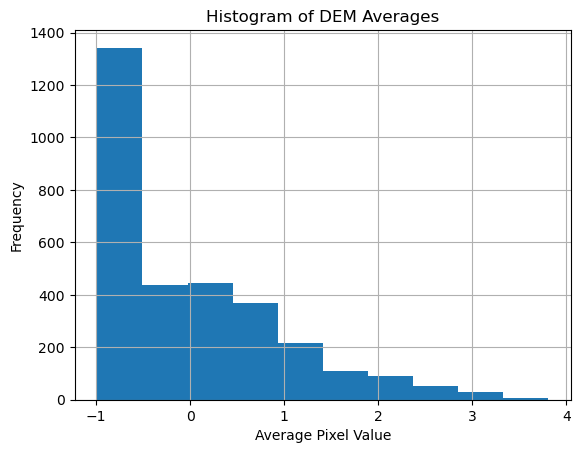

In [5]:
import matplotlib.pyplot as plt

# Head of DEM averages
dem_averages = read_scene_averages(output_dir_dem, prefix="DEM")
plt.hist(np.array(dem_averages)[:,1])
plt.title("Histogram of DEM Averages")
plt.xlabel("Average Pixel Value")
plt.ylabel("Frequency")
plt.grid()
plt.show()